In [1]:
#!pip install keras
#!pip install tensorflow
#!pip install scikeras
#!pip install jupyter_contrib_nbextensions
#!jupyter contrib nbextension install --user

In [2]:
import csv
import itertools
import warnings
import nltk
import pandas as pd
import sklearn
import numpy as np
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import tensorflow as tf
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.layers import Input, Dense, InputLayer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam # - Works
import matplotlib.pyplot as plt

from scikeras.wrappers import KerasClassifier
warnings.filterwarnings(action='ignore')

In [3]:
def simplified_preprocessing(filename):
    header = ["train_id", "Sentence_1", "Sentence_2", "Output"]
    df = pd.read_csv(filename, sep='\t', names=header, engine='python', encoding='utf8', error_bad_lines=False,
                     quoting=csv.QUOTE_NONE)
    # Make all words lowercase
    df['Sentence_1'] = df['Sentence_1'].str.lower()
    df['Sentence_2'] = df['Sentence_2'].str.lower()

    return df


def bleu_score(sentence1array, sentence2array):
    features = pd.DataFrame(columns=["BLEU_1", "BLEU_2", "BLEU_3", "BLEU_4"])
    bleu1 = []
    bleu2 = []
    bleu3 = []
    bleu4 = []

    for (sentence_1, sentence_2) in itertools.zip_longest(sentence1array, sentence2array):
        first_sentence = nltk.word_tokenize(sentence_1)
        second_sentence = nltk.word_tokenize(sentence_2)
        bleu1.append(nltk.translate.bleu_score.sentence_bleu([first_sentence], second_sentence,
                                                             weights=[1]))
        bleu2.append(nltk.translate.bleu_score.sentence_bleu([first_sentence], second_sentence,
                                                             weights=[0.5, 0.5]))
        bleu3.append(nltk.translate.bleu_score.sentence_bleu([first_sentence], second_sentence,
                                                             weights=[1 / 3, 1 / 3, 1 / 3]))
        bleu4.append(nltk.translate.bleu_score.sentence_bleu([first_sentence], second_sentence,
                                                             weights=[1 / 4, 1 / 4, 1 / 4, 1 / 4]))

    features["BLEU_1"] = bleu1
    features["BLEU_2"] = bleu2
    features["BLEU_3"] = bleu3
    features["BLEU_4"] = bleu4

    return features


def meteor_scores(sentence1array, sentence2array):
    features = pd.DataFrame(columns=["METEOR"])

    meteor_score = []
    for (sentence_1, sentence_2) in itertools.zip_longest(sentence1array, sentence2array):
        first_sentence = nltk.word_tokenize(sentence_1)
        second_sentence = nltk.word_tokenize(sentence_2)
        meteor_score.append(nltk.translate.meteor_score.single_meteor_score(first_sentence, second_sentence))
    features["METEOR"] = meteor_score
    return features


def character_bigrams_features(sentence1array, sentence2array):
    features = pd.DataFrame(columns=["CharacterBigramUnion", "CharacterBigramIntersection",
                                     "NumCharBigrams1", "NumCharBigrams2",
                                     ])
    bigramUnion = []
    bigramIntersection = []
    numbigrams1 = []
    numbigrams2 = []

    for (sentence_1, sentence_2) in itertools.zip_longest(sentence1array, sentence2array):
        sentence_1_no_spaces = sentence_1.replace(" ", "")
        sentence_2_no_spaces = sentence_2.replace(" ", "")
        sentence_1_char_bigrams = [sentence_1_no_spaces[i:i + 2] for i in range(len(sentence_1_no_spaces) - 1)]
        sentence_2_char_bigrams = [sentence_2_no_spaces[i:i + 2] for i in range(len(sentence_2_no_spaces) - 1)]
        bigram_matches = 0
        for phrase in sentence_1_char_bigrams:
            if phrase in sentence_2_char_bigrams:
                bigram_matches += 1
        bigramIntersection.append(bigram_matches)
        bigramUnion.append(len(sentence_1_char_bigrams) + len(sentence_2_char_bigrams))
        numbigrams1.append(len(sentence_1_char_bigrams))
        numbigrams2.append(len(sentence_2_char_bigrams))
    features["CharacterBigramUnion"] = bigramUnion
    features["CharacterBigramIntersection"] = bigramIntersection
    features["NumCharBigrams1"] = numbigrams1
    features["NumCharBigrams2"] = numbigrams2

    return features


def word_unigram_features(sentence1array, sentence2array):
    features = pd.DataFrame(columns=["SentenceUnigramUnion", "SentenceUnigramIntersection",
                                     "NumSentUnigrams1", "NumSentUnigrams2"])
    unigramUnion = []
    unigramIntersection = []
    numunigrams1 = []
    numunigrams2 = []

    for (sentence_1, sentence_2) in itertools.zip_longest(sentence1array, sentence2array):
        sentence_1_words = nltk.word_tokenize(sentence_1)
        sentence_2_words = nltk.word_tokenize(sentence_2)
        sentence_1_unigrams = list(nltk.ngrams(sentence_1_words, 1))
        sentence_2_unigrams = list(nltk.ngrams(sentence_2_words, 1))
        unigram_matches = 0
        for phrase in sentence_1_unigrams:
            if phrase in sentence_2_unigrams:
                unigram_matches += 1
        unigramIntersection.append(unigram_matches)
        unigramUnion.append(len(sentence_1_unigrams) + len(sentence_2_unigrams))
        numunigrams1.append(len(sentence_1_unigrams))
        numunigrams2.append(len(sentence_2_unigrams))
    features["SentenceUnigramUnion"] = unigramUnion
    features["SentenceUnigramIntersection"] = unigramIntersection
    features["NumSentUnigrams1"] = numunigrams1
    features["NumSentUnigrams2"] = numunigrams2
    return features


def all_features(sentence1array, sentence2array):
    features = pd.DataFrame(columns=[
        "BLEU_1", "BLEU_2", "BLEU_3", "BLEU_4",
        "Meteor Score",
        "CharacterBigramUnion", "CharacterBigramIntersection", "NumCharBigrams1", "NumCharBigrams2",
        "SentenceUnigramUnion", "SentenceUnigramIntersection", "NumSentUnigrams1", "NumSentUnigrams2",
    ])
    bleu_scores = bleu_score(sentence1array, sentence2array)

    features["BLEU_1"] = bleu_scores["BLEU_1"]
    features["BLEU_2"] = bleu_scores["BLEU_2"]
    features["BLEU_3"] = bleu_scores["BLEU_3"]
    features["BLEU_4"] = bleu_scores["BLEU_4"]

    features["Meteor Score"] = meteor_scores(sentence1array, sentence2array)

    char_bigram = character_bigrams_features(sentence1array, sentence2array)
    word_unigram = word_unigram_features(sentence1array, sentence2array)

    features["CharacterBigramUnion"] = char_bigram["CharacterBigramUnion"]
    features["CharacterBigramIntersection"] = char_bigram["CharacterBigramIntersection"]
    features["NumCharBigrams1"] = char_bigram["NumCharBigrams1"]
    features["NumCharBigrams2"] = char_bigram["NumCharBigrams2"]

    features["SentenceUnigramUnion"] = word_unigram["SentenceUnigramUnion"]
    features["SentenceUnigramIntersection"] = word_unigram["SentenceUnigramIntersection"]
    features["NumSentUnigrams1"] = word_unigram["NumSentUnigrams1"]
    features["NumSentUnigrams2"] = word_unigram["NumSentUnigrams2"]

    return features


def get_device():
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
    else:
        device = torch.device('cpu')  # don't have GPU
    return device


def df_to_tensor(df):
    device = get_device()
    return torch.from_numpy(df.values).float().to(device)

In [4]:
# nltk.download('punkt')
# nltk.download('wordnet')

In [5]:
training_data = simplified_preprocessing("train_with_label.txt")
X = all_features(training_data["Sentence_1"], training_data["Sentence_2"])
y = training_data["Output"]

dev_data = simplified_preprocessing("dev_with_label.txt")
Xdev = all_features(dev_data["Sentence_1"], dev_data["Sentence_2"])
ydev = dev_data["Output"]

In [6]:
number_of_classes = 2
number_of_features = 13
model = Sequential()
model.add(Dense(number_of_classes, activation='sigmoid', input_dim=number_of_features))
model.compile(optimizer='adam', loss='binary_crossentropy')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 2)                 28        
                                                                 
Total params: 28
Trainable params: 28
Non-trainable params: 0
_________________________________________________________________


In [7]:
print(X.shape)
print(y.shape)
print(Xdev.shape)
print(ydev.shape)

(7801, 13)
(7801,)
(4000, 13)
(4000,)


In [8]:
ANN_model = Sequential()
ANN_model.add(InputLayer(13,))
ANN_model.add(Dense(1,activation='sigmoid'))
ANN_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 1)                 14        
                                                                 
Total params: 14
Trainable params: 14
Non-trainable params: 0
_________________________________________________________________


In [9]:
optimizer= tf.keras.optimizers.Adam(learning_rate=0.05)
ANN_model.compile(
    optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

history = ANN_model.fit(X, y, 
                        epochs=10, batch_size=32,
                        validation_split=0.2, 
                        shuffle=False)

Epoch 1/10
195/195 [==============================] - 1s 4ms/step - loss: 4.1182 - accuracy: 0.7402 - val_loss: 0.3290 - val_accuracy: 0.8661
Epoch 2/10
195/195 [==============================] - 1s 3ms/step - loss: 0.4692 - accuracy: 0.8293 - val_loss: 0.3188 - val_accuracy: 0.8732
Epoch 3/10
195/195 [==============================] - 0s 2ms/step - loss: 0.4660 - accuracy: 0.8399 - val_loss: 0.3136 - val_accuracy: 0.8808
Epoch 4/10
195/195 [==============================] - 0s 2ms/step - loss: 0.4656 - accuracy: 0.8449 - val_loss: 0.2977 - val_accuracy: 0.8853
Epoch 5/10
195/195 [==============================] - 1s 3ms/step - loss: 0.5022 - accuracy: 0.8421 - val_loss: 0.3618 - val_accuracy: 0.8732
Epoch 6/10
195/195 [==============================] - 1s 4ms/step - loss: 0.4937 - accuracy: 0.8439 - val_loss: 0.3604 - val_accuracy: 0.8725
Epoch 7/10
195/195 [==============================] - 0s 2ms/step - loss: 0.5366 - accuracy: 0.8389 - val_loss: 0.5345 - val_accuracy: 0.8495
Epoch 

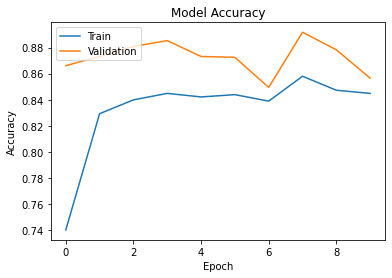

In [10]:
# Plot training and validation accuracy scores
# against the number of epochs.
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.title('Model Accuracy')
plt.legend(loc='upper left')

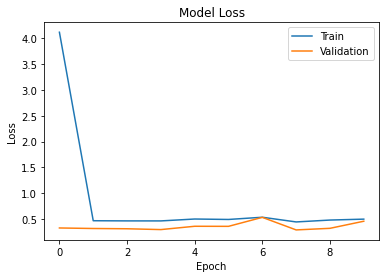

In [11]:
# Plot training and validation loss scores
# against the number of epochs.
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Model Loss')
plt.legend(loc='upper right')

In [12]:
test_loss, test_acc = ANN_model.evaluate(Xdev, ydev)
print("Test loss:", test_loss)
print("Test accuracy:", test_acc)

125/125 [==============================] - 0s 2ms/step - loss: 0.5258 - accuracy: 0.8375
Test loss: 0.5257931351661682
Test accuracy: 0.8374999761581421
